<a href="https://colab.research.google.com/github/HHH023/coastline_extraction/blob/main/coastline_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import and initialize the Earth Engine library.
import ee
service_account = 'mscproject@coastline-extraction-6823.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'coastline-extraction-6823-b14b6de1d028.json')
ee.Initialize(credentials)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ee.Authenticate()
ee.Initialize()

In [6]:
import folium
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)
# data visualization
folium.Map.add_ee_layer = add_ee_layer

In [7]:
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask).divide(10000)
  
rec = ee.Geometry.Rectangle([151.486, -33.373, 151.499, -33.364])

# Load Sentinel-2 TOA reflectance data
# Pre-filter to get less cloudy granules.
dataset = (ee.ImageCollection('COPERNICUS/S2')
       .filterBounds(rec)
       .filterDate('2019-01-01', '2019-06-30')  
       .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
       .map(maskS2clouds))

map = folium.Map(location=[-33.369513, 151.491883], zoom_start=10)

# display the first image
map.add_ee_layer(dataset.first(), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'rgb');
display(map)

**Use geetools to export image collection**

In [ ]:
!pip install geetools

In [ ]:
help(geetools.batch.Export.imagecollection.toDrive)

In [ ]:
import geetools

# ## Define an ImageCollection
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60']
site = ee.Geometry.Rectangle([151.486, -33.373, 151.499, -33.364])
collection = (ee.ImageCollection('COPERNICUS/S2')
       .filterBounds(site)
       .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
       .select(bands))

# Set parameters
scale = 10
name_pattern = '{system_date}'
## the keywords between curly brackets can be {system_date} for the date of the
## image (formatted using `date_pattern` arg), {id} for the id of the image
## and/or any image property. You can also pass extra keywords using the `extra`
## argument. Also, numeric values can be formatted using a format string (as
## shown in {WRS_PATH:%d} (%d means it will be converted to integer)
date_pattern = 'ddMMMy' # dd: day, MMM: month (JAN), y: year
folder = 'dataset'
data_type = 'uint32'
region = site

# ## Export
tasks = geetools.batch.Export.imagecollection.toDrive(
            collection=collection,
            folder=folder,
            namePattern=name_pattern,
            region=site,
            scale=scale,
            dataType=data_type,
            datePattern=date_pattern,
            verbose=True,
        )


**Load image from google drive and convert to numpy array**

In [ ]:
!pip install rasterio

In [10]:
import os
import rasterio as rio


raster_path = os.path.join('drive/MyDrive', 'land_geotiff_add', '31May2021_20210531T110621_20210531T111450_T30UVU')
l8_raster_path = ".".join([raster_path, "tif"])

# Check some attributes
with rio.open(l8_raster_path, 'r') as l8_raster:
  print(l8_raster.bounds)
  print(l8_raster.meta)

BoundingBox(left=421730.0, bottom=5302970.0, right=422750.0, top=5304000.0)
{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': None, 'width': 102, 'height': 103, 'count': 14, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 421730.0,
       0.0, -10.0, 5304000.0)}


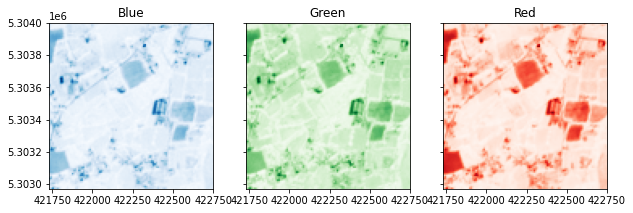

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

with rio.open(l8_raster_path, 'r') as l8_raster:
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

  # Plot Red, Green and Blue (rgb)
  show((l8_raster, 2), cmap='Blues', ax=ax1)
  show((l8_raster, 3), cmap='Greens', ax=ax2)
  show((l8_raster, 4), cmap='Reds', ax=ax3)

  # Add titles
  ax1.set_title("Blue")
  ax2.set_title("Green")
  ax3.set_title("Red")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


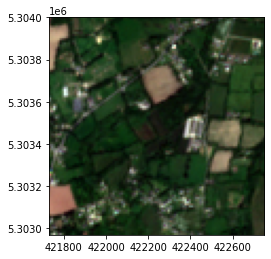

In [15]:
from rasterio.plot import reshape_as_image

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Open and read the raster data
with rio.open(l8_raster_path, 'r') as l8_raster:
  l8_data = l8_raster.read()
  
# To plot as RGB we have to normalize the data
l8_image = np.empty(l8_data.shape, dtype=np.float)
for band in range(l8_data.shape[0]):
  l8_image[band] = normalize(l8_data[band])


fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, 4), sharey=True)
show(l8_image[[3,2,1],:,:], transform=l8_raster.transform, adjust='linear', ax=ax1) # RGB

**Convert ee image to numpy array**

This method has limitions on pixels numbers. Therefore, using rasterio to convert is better. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt 

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60']
first_image = dataset.first().select(bands)
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = first_image.sampleRectangle(region=rec, defaultValue=0)

# R,G,B and NIR bands have 10m resolution
# B2, B3, B4, B8

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B4')
band_arr_b3 = band_arrs.get('B3')
band_arr_b2 = band_arrs.get('B2')

(103, 123)
(103, 123)
(103, 123)
(103, 123, 1)
(103, 123, 1)
(103, 123, 1)
(103, 123, 3)


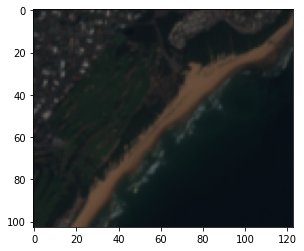

In [18]:
# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b2 = np.array(band_arr_b2.getInfo())
np_arr_b3 = np.array(band_arr_b3.getInfo())
np_arr_b4 = np.array(band_arr_b4.getInfo())
print(np_arr_b2.shape)
print(np_arr_b3.shape)
print(np_arr_b4.shape)

np_arr_b2 = np.expand_dims(np_arr_b2, 2)
np_arr_b3 = np.expand_dims(np_arr_b3, 2)
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
print(np_arr_b2.shape)
print(np_arr_b3.shape)
print(np_arr_b4.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b4, np_arr_b3, np_arr_b2), 2)
#rgb_img = np.dstack((np_arr_b2,np_arr_b3,np_arr_b4,np_arr_b8))
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
#rgb_img_test = (255*(rgb_img/0.35)).astype('uint8') # TOA imagery
rgb_img_test = (rgb_img*255) .astype(np.uint8) 
plt.imshow(rgb_img_test)
plt.show()

In [20]:
import cv2

(52, 62)
(103, 123)
(103, 123, 1)


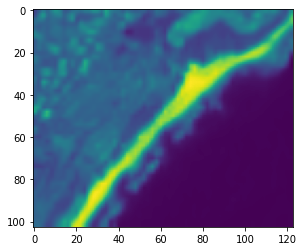

In [21]:
# resolution 20m to 10m
# B5, B6, B7, B8A, B11, B12

band_arr_20 = band_arrs.get('B5')
np_arr_20 = np.array(band_arr_20.getInfo())
print(np_arr_20.shape)
plt.imshow(np_arr_20)
# bilinear interpolation
np_arr_20 = cv2.resize(np_arr_20, (123, 103), interpolation = cv2.INTER_LINEAR)
print(np_arr_20.shape)
plt.imshow(np_arr_20)
np_arr_20 = np.expand_dims(np_arr_20, 2)
print(np_arr_20.shape)

(18, 22)
(103, 123)
(103, 123)


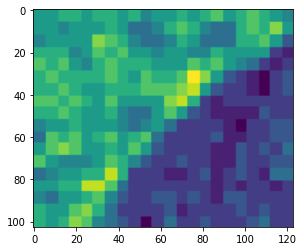

In [22]:
# resolution 60m to 10m
# B1, B9, B10, QA60

band_arr_60 = band_arrs.get('B10')
np_arr_60 = np.array(band_arr_60.getInfo())
print(np_arr_60.shape)
plt.imshow(np_arr_60)
# nearest neighbor interpolation
np_arr_60 = cv2.resize(np_arr_60, (123, 103), interpolation = cv2.INTER_NEAREST)
print(np_arr_60.shape)
plt.imshow(np_arr_60)
np_arr_qa60 = np.expand_dims(np_arr_60, 2)
print(np_arr_60.shape)

**Show clipped image on the interative map**

In [23]:
# Mosaic the visualization layers and display (or export).
mosaic = ee.ImageCollection(dataset.first()).mosaic()

In [24]:
#rec = ee.Geometry.Rectangle([151.487, -33.372, 151.496, -33.366])
mosaic_clipped = dataset.first().clip(rec)

# Define a map centered on San Francisco.
map_mosaic_clipped = folium.Map(location=[-33.369513, 151.491883], zoom_start=16)

# Add the image layer to the map and display it.
map_mosaic_clipped.add_ee_layer(mosaic_clipped, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.4}, 'mosaic clipped')
display(map_mosaic_clipped)

**CNN Classifier**

Deep learning with CIFAR-10 using ResNet-18

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [37]:
# Data transforms (normalization & data augmentation)
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# image = (image - mean) / std 

batch_size = 128

trainsset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)

trainset,validset = random_split(trainsset,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tfms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


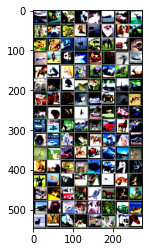

 ship  deer  ship  deer   cat  ship   car  deer  bird   car  frog   cat  ship  ship   dog horse  deer  frog   car  deer truck horse  ship  bird plane horse truck  ship   car horse  bird  ship horse truck   cat  frog  frog truck  frog  deer truck   car  bird  frog  frog truck  ship  bird truck horse  frog   dog  ship   car  deer  deer  deer  bird  frog  bird   car  deer   car  bird   car  ship  frog plane   dog   car horse   car   dog  ship   cat  frog horse truck  frog   car  bird  deer   car   cat truck   car  ship  deer  frog  deer  frog  deer   dog   car  bird  bird   dog plane   cat plane  ship plane   dog  bird   cat  frog truck  frog   cat horse  frog  bird plane   dog plane  frog   dog  frog truck  ship  deer  deer truck   dog horse  bird truck horse


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # nuumpy uses channel*width*height, while the pytorch uses width*height*channel
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

torch.cuda.empty_cache()

cuda:0


In [40]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes) )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes) )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

net = ResNet18().to(device)

In [41]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# stochastic gradient descent
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 52, eta_min=0.0001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [15,35], gamma=0.1)
 

In [42]:
best_val_acc = -1000
PATH = './cifar_net.pth'

for epoch in range(50):  # loop over the dataset multiple times
    
    net.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0 

    ####### training set #######
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  # update

        # print statistics
        running_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
    print('[epoch %d]  loss: %.3f, accuraccy: %.3f %%' %
                  (epoch + 1, running_loss/len(trainset), 100*running_correct/len(trainset)))


    ####### validation set #######
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the validation set: %.3f %%' % (
                     100 * correct / total))

    if correct>best_val_acc:
        best_val_acc = correct
        torch.save(net.state_dict(), PATH)
    lr_scheduler.step() 
print('Finished Training')

[epoch 1]  loss: 1.485, accuraccy: 45.738 %
Accuracy of the network on the validation set: 51.737 %
[epoch 2]  loss: 1.006, accuraccy: 63.702 %
Accuracy of the network on the validation set: 62.163 %
[epoch 3]  loss: 0.789, accuraccy: 72.231 %
Accuracy of the network on the validation set: 72.362 %
[epoch 4]  loss: 0.648, accuraccy: 77.338 %
Accuracy of the network on the validation set: 76.100 %
[epoch 5]  loss: 0.567, accuraccy: 80.252 %
Accuracy of the network on the validation set: 77.638 %
[epoch 6]  loss: 0.498, accuraccy: 82.569 %
Accuracy of the network on the validation set: 78.725 %
[epoch 7]  loss: 0.447, accuraccy: 84.433 %
Accuracy of the network on the validation set: 79.737 %
[epoch 8]  loss: 0.409, accuraccy: 85.907 %
Accuracy of the network on the validation set: 81.688 %
[epoch 9]  loss: 0.371, accuraccy: 87.064 %
Accuracy of the network on the validation set: 85.150 %
[epoch 10]  loss: 0.353, accuraccy: 87.693 %
Accuracy of the network on the validation set: 82.987 %

In [43]:
correct = 0
total = 0
net.load_state_dict(torch.load(PATH))
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91.970 %


In [44]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 94.8 %
Accuracy for class car   is: 97.1 %
Accuracy for class bird  is: 87.6 %
Accuracy for class cat   is: 82.8 %
Accuracy for class deer  is: 93.2 %
Accuracy for class dog   is: 86.0 %
Accuracy for class frog  is: 94.1 %
Accuracy for class horse is: 94.4 %
Accuracy for class ship  is: 95.3 %
Accuracy for class truck is: 94.4 %
